
This is a table of NaN values count. Let's remove top 3 rows from our dataset.

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
MSSubClass          0
Length: 80, dtype: int64

LotFrontage null values:259
Id
1058     True
1194     True
846      True
497      True
1178     True
        ...  
923     False
924     False
925     False
927     False
1       False
Name: LotFrontage, Length: 1460, dtype: bool

GarageYrBlt null values:81
Id
376      True
1144     True
465      True
969      True
827      True
        ...  
959     False
960     False
962     False
963     False
1       False
Name: GarageYrBlt, Length: 1460, dtype: bool

Lets fill missing values with mean of the column


These two feature's values are too big, so we will apply log to the columns




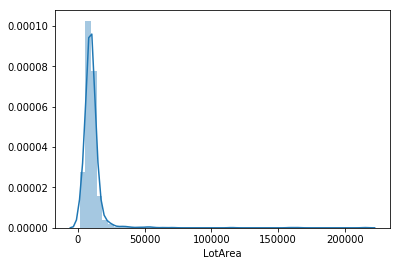

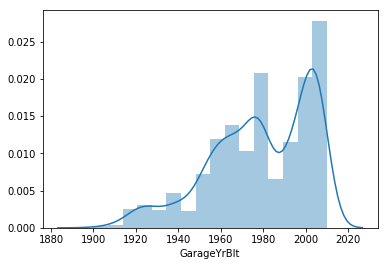


Everything looks so linear except these two bottom estates. Let's remove these outlines


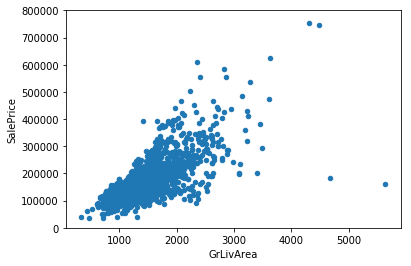


Final results: 
Train score:       Test score:
0.9408792251356011 0.9367113862063692


In [47]:
import sys
import numpy as np
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])
del test
print("\nThis is a table of NaN values count. Let's remove top 3 rows from our dataset.\n")
pd.options.display.max_rows = 10
print(train.isnull().sum().sort_values(ascending = False))
train = train.drop(labels=['PoolQC', 'Alley', 'MiscFeature'], axis=1)
print("\nLotFrontage null values:" + str(train['LotFrontage'].isnull().sum()))
lot_frontage_null = train['LotFrontage'].isnull().sort_values(ascending = False)
print(lot_frontage_null)
print("\nGarageYrBlt null values:" + str(train['GarageYrBlt'].isnull().sum()))
garage_yr_blt_null = train['GarageYrBlt'].isnull().sort_values(ascending = False)
print(garage_yr_blt_null)
print("\nLets fill missing values with mean of the column")
#fill missing values
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())
train_no_sale_price = train.drop(labels=['SalePrice'], axis=1)
from sklearn.model_selection import train_test_split
train_sale_price = train['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(train_no_sale_price, 
                                                    train_sale_price, 
                                                    test_size=0.3, 
                                                    random_state=4330)
print("\n\nThese two feature's values are too big, so we will apply log to the columns\n\n")
diag_one = sns.distplot(train.LotArea, norm_hist = False);
plt.show()
diag_two = sns.distplot(train.GarageYrBlt);
plt.show()
#make big numeric functions ln
x_train['LotArea'] = pd.np.log(x_train['LotArea'])
x_test['LotArea'] = pd.np.log(x_test['LotArea'])
x_train['GrLivArea'] = pd.np.log(x_train['GrLivArea'])
x_test['GrLivArea'] = pd.np.log(x_test['GrLivArea'])
print("\nEverything looks so linear except these two bottom estates. Let's remove these outlines")
outliners = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1).plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))
plt.show()
#remove 2 outliners found in GrLivArea
x_train = x_train.drop([1299, 524])
y_train = y_train.drop([1299, 524])

from sklearn.linear_model import LinearRegression

numeric_columns_names = x_train.describe().columns
x_train[numeric_columns_names] = x_train[numeric_columns_names].fillna(0)
x_test[numeric_columns_names] = x_test[numeric_columns_names].fillna(0)

from sklearn.preprocessing import LabelEncoder
categorical_columns = train.dtypes[train.dtypes == 'object'].index

train = train.fillna("")
encoders = {col: LabelEncoder().fit(train[col]) for col in categorical_columns}
def encode_categorical(data, columns, encoders):
    data = data.fillna("")
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)
from sklearn.preprocessing import OneHotEncoder
train_encoded = encode_categorical(train, categorical_columns, encoders)

one_hot_encoder = OneHotEncoder().fit(train_encoded)
one_hot_x_train = one_hot_encoder.transform(encode_categorical(x_train[categorical_columns], categorical_columns, encoders))
one_hot_x_test = one_hot_encoder.transform(encode_categorical(x_test[categorical_columns], categorical_columns, encoders))

new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train[numeric_columns_names]], axis=1)
new_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test[numeric_columns_names]], axis=1)

from sklearn.linear_model import Ridge
all_data_lr = LinearRegression().fit(new_x_train, pd.np.log10(y_train))
all_data_lr = Ridge(alpha = 10).fit(new_x_train, pd.np.log10(y_train))
print("\nFinal results: \nTrain score:       Test score:")
print(all_data_lr.score(new_x_train, pd.np.log10(y_train)), all_data_lr.score(new_x_test, pd.np.log10(y_test)))